# ANLP 2020 - Assignment 2

*Sophia Student, 1234567* (enter your name/student id number here)

<div class="alert alert-block alert-danger">Due: Wednesday, December 16, 2020, 10am</div>

<div class="alert alert-block alert-info">

**NOTE**
<br><br>

Please first fill in your name and id number at the top of the assignment, and **rename** the assignment file to **yourlastname-anlp-4.ipynb**<br><br>
Problems and questions are given in blue boxes like this one. All grey and white boxes must be filled by you (they either require code or a (brief!) discussion). <br><br>
Please hand in your assignment by the deadline via Moodle. In case of questions, you can contact the TAs or David via the usual channels.

</div>

<div class="alert alert-block alert-info">
    
In this assignment, you will implement a feedforward neural network and train it with backpropagation to classify intent from the provided dataset (<https://github.com/Dark-Sied/Intent_Classification>). For the purpose of understanding the learning process, the whole dataset is used as both training and test data. (What does that mean for your results?)<br><br>

You should implement all part of this exercise using only python + standard library + NumPy. (That is, no specialised machine learning libraries are allowed.) Here is a list of NumPy functions that may or may not be useful for this task: <br>
`np.array(), np.eye(), np.reshape(), np.ones(), np.zeros(), np.dot(), np.concatenate(), np.maximum(), np.argmax(), np.sum(), np.uniform()`. <br><br>

A more comprehensive introduction to NumPy can be found here: <https://sites.engineering.ucsb.edu/~shell/che210d/numpy.pdf> .

</div>

In [1]:
import csv
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# For your convenience, a function for reading in the dataset:
def load_dataset(filename):
    intent = []
    unique_intent = []
    sentences = []
    with open(filename, "r", encoding="latin1") as f:
        data = csv.reader(f, delimiter=",")
        for row in data:
            sentences.append(row[0])
            intent.append(row[1])
    unique_intent = set(intent)
    return sentences, intent, unique_intent
            
sentences, intent, unique_intent = load_dataset("dataset/dataset.csv")

## Problem 1: Bag-of-Words Representation [15pts]

<div class="alert alert-block alert-info">

The first thing you're being asked to do is to convert the text into a bag-of-words representation matrix where the dimension of the matrix is $V$ x $M$ ($M$: number of examples, $V$: vocabulary size) and the label to a matrix of dimension $K$ x $M$ where $K$ is number of classes.   

</div>

In [3]:
# Student solution here.
def make_array(sentences, intent, unique_intent):
    vocab = []
    sentences = [w.split() for w in sentences]
    for lst in sentences:
        vocab+=lst
    vocab = np.asarray(list(set(vocab)))
    unique_intent = list(unique_intent)
    xtr = np.zeros((len(vocab), len(sentences)))
    ytr = np.zeros((len(unique_intent), len(sentences)))
    for col, (lst, label) in enumerate(zip(sentences, intent)):
        r = unique_intent.index(label)
        ytr[r,col] = 1
        uniq, counts = np.unique(np.asarray(lst), return_counts = True)
        ii = [np.where(vocab == d)[0].item() for d in uniq]
        xtr[ii, col] = counts
    return xtr, ytr

In [4]:
xtr, ytr = make_array(sentences, intent, unique_intent)

## Problem 2: Activation Function [15 pts]

<div class="alert alert-block alert-info">
    
For the classification task, the softmax activation function for the output layer with K classes is given by: 
$softmax(z_i) = \frac{e^{z_i}}{{\sum_{j=1}^{K}e^{z_j}}}$ <br>
The activation function of the hidden neurons is a non-linear function. We have seen tanh being used in class, but more common these days are for example ReLU or sigmoid, given by: <br>
$ReLU(z)=max(0,z)$ <br>
$sigmoid(z)=\frac{1}{1+e^{-z}}$ <br>

Implement the softmax, ReLU, and sigmoid activation function in such a way that it accepts NumPy array and matrices. Plot the ReLU and sigmoid functions, as well as their derivatives. Observe the plot and discuss briefly what the advantages and disadvantages of the ReLU and sigmoid activation function might be. 

</div>

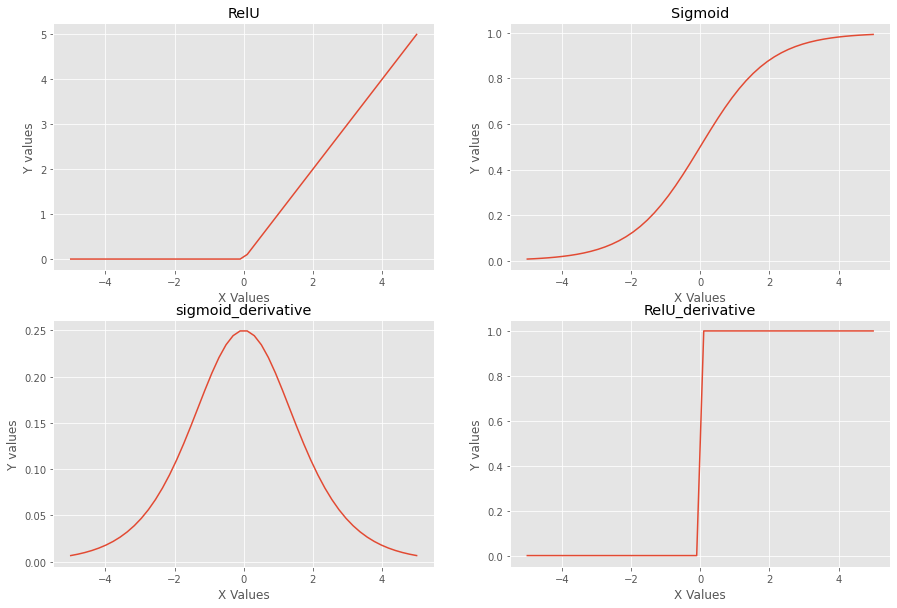

In [7]:
# Student solution here.
def softmax(x):
    if x.ndim > 1:
        return np.exp(x)/(np.sum(np.exp(x), axis= 1)).reshape(-1,1)
    else:
        return np.exp(x)/np.sum(np.exp(x))

def RelU(x):
    return np.where(x>0, x, 0)

def sigmoid(x):
    return 1/(1 + np.exp(-1*x))

def sigmoid_derivative(x):
    s = sigmoid(x)
    return s*(1-s)

def RelU_derivative(x):
    return np.where(x>0, 1, 0)

xx = np.linspace(-5,5,50)
fig, ax = plt.subplots(2,2, figsize = (15,10))
ax = ax.reshape(-1)
plt.style.use("ggplot")
func = [RelU, sigmoid, sigmoid_derivative, RelU_derivative]
y_label = ['RelU', 'Sigmoid', 'sigmoid_derivative', 'RelU_derivative']
for i, f in enumerate(func):
    ax[i].plot(xx, f(xx))
    ax[i].set_xlabel("X Values")
    ax[i].set_ylabel("Y values")
    ax[i].set_title(y_label[i])



Your discussion here

## Problem 3: Feedforward Neural Network [35 pts]

<div class="alert alert-block alert-info">
    
Now that you have created the input matrix, we can implement our neural network and perform a forward propagation to classify intent. To perform the forward propagation, you should compute $z^{l}$ and pass it through the activation function for each layer, given by: <br><br>
$z^{l} = W^{l}a^{l-1} + b^{l}$ <br>
$a^{l} = g(z^{l})$ <br>
where $W^{l}$ is a weight matrix between layer $l$ and $l+1$, $z^{l}$ is value of the hidden layer at layer $l$ before activation, $a^{l}$ is value of the hidden layer at layer $l$ after activation, and $b^{l}$ is bias term for layer $l$.

You should implement the feedforward computation that computes $\hat{y_{i}}$ for every example $i$. The neural network has 3 layers - an input layer, a hidden layer and an output layer, where the hidden layer has 150 neurons. Don't forget to include the bias term. Use ReLU as the activation function for the hidden layer and softmax for the output layer. For parameters initialization, use random values from uniform distribution in the range (-1,1). Provide a seed value to the random number generator, to make the results reproducible. The purpose of using this kind of initialisation is to break symmetry and ensure that different neurons can learn different non-linear functions. (Hint: use vectorization methods instead of a for loop for speedup.) <br><br>

Use this neural network to predict the intent and calculate the accuracy of the classifier. (Should you be expecting high numbers yet?)

</div>

In [22]:
ytr = ytr.T
xtr = xtr.T

In [21]:
# # Student solution here.
# def forward_pass(xtr, ytr,  hidden_units = 150):
    # xtr : vocab_size x examples
    # ytr : classes x examples
hidden_units = 150
np.random.seed(42)
w1 = np.random.uniform(-1,1, size = (xtr.shape[1], hidden_units))
b1 = np.random.uniform(-1,1, size = (1, hidden_units))
w2 = np.random.uniform(-1,1, size = (hidden_units, ytr.shape[1]))
b2 = np.random.uniform(-1,1, size = (1, ytr.shape[1]))
z1 = np.matmul(xtr, w1) + b1
y1 = RelU(z1)
z2 = np.matmul(y1, w2) + b2
y2 = softmax(z2)
acc = np.sum(np.argmax(y2, axis= 1) == np.argmax(ytr, axis= 1))/(ytr.shape[0])
print(f"The accuracy is: {acc*100}%")


The accuracy is: 2.605570530098832%


In [16]:
class Model():
    def __init__(self, xtr, ytr, hidden_unit = 150):
        np.random.seed(42)
        self.hidden_units = hidden_unit
        self.xtr = xtr.T
        self.ytr = ytr.T
        self.w1 = np.random.uniform(-1,1, size = (self.xtr.shape[1], self.hidden_units))
        self.b1 = np.random.uniform(-1,1, size = (1, self.hidden_units))
        self.w2 = np.random.uniform(-1,1, size = (self.hidden_units, self.ytr.shape[1]))
        self.b2 = np.random.uniform(-1,1, size = (1, self.ytr.shape[1]))
    
    def forward_pass(self):
        # xtr :  number of examples x vocab_size
        self.z1 = np.matmul(self.xtr, self.w1) + self.b1
        self.y1 = RelU(self.z1)
        self.z2 = np.matmul(self.y1, self.w2) + self.b2
        self.y2 = softmax(self.z2)
        acc = np.sum(np.argmax(self.y2, axis= 1) == np.argmax(self.ytr, axis= 1))/(self.ytr.shape[0])
        print(f"The accuracy is: {acc*100}%")

    def back_prop(self):
        pass


In [18]:
model = Model(xtr, ytr)
model.forward_pass()

The accuracy is: 2.605570530098832%


## Problem 4: Backpropagation [35 pts]

In [258]:
xtr, ytr = make_array(sentences, intent, unique_intent)

In [259]:
ytr = ytr.T
xtr = xtr.T

In [260]:
# # Student solution here.
# def forward_pass(xtr, ytr,  hidden_units = 150):
    # xtr : vocab_size x examples
    # ytr : classes x examples
hidden_units = 150
np.random.seed(42)
w1 = np.random.uniform(-1,1, size = (xtr.shape[1], hidden_units))
b1 = np.random.uniform(-1,1, size = (1, hidden_units))
w2 = np.random.uniform(-1,1, size = (hidden_units, ytr.shape[1]))
b2 = np.random.uniform(-1,1, size = (1, ytr.shape[1]))
z1 = np.matmul(xtr, w1) + b1
y1 = RelU(z1)
z2 = np.matmul(y1, w2) + b2
y2 = softmax(z2)
acc = np.sum(np.argmax(y2, axis= 1) == np.argmax(ytr, axis= 1))/(ytr.shape[0])
print(f"The accuracy is: {acc*100}%")


The accuracy is: 3.7735849056603774%


<div class="alert alert-block alert-info">
    
You will now implement the backpropagation algorithm to compute the gradient of the cost function with respect to the neural network weights' and bias term.  First of all, implement the cross entropy loss function to monitor if your model is actually learning. Remember that in backpropagation, we want to propagate the error signal to measure how much each neuron in the hidden layer contributes to the error in the output layer. It is more or less similar to forward propagation but in a reverse direction. For the output layer, set $\delta$ for cross entropy loss: <br><br>
$\delta^{L}= \hat{y} - y$ <br> where $L$ is the output layer and $\hat{y}$ is prediction of $y$. <br>

For the remaining hidden layer $l$, set: <br><br>
$\delta^{l} = (W^{l})^{T}\delta^{l+1} \odot g'(z^{l})$ <br> where $\odot$ is an element-wise product of matrices (Hadamard product), $g'$ is the derivative of the activation function. <br>

The derivative of the ReLU is given by:  $ReLU'(z) = \begin{cases} 1 & \text{if } z > 0 \\
                                                                                                                                      0 & \text{otherwise}.\end{cases}$<br>

By calculating the error term for each layer, you can then use the error term to calculate the partial derivatives $\frac{\partial \mathcal{L}}{\partial W^{l}} = \delta_{l+1} (a^{l})^{T}$ and $\frac{\partial \mathcal{L}}{\partial b^{l}} = \delta_{l+1}$ and perform batch gradient descent to update the parameter. (Batch gradient descent = run through all training instances and compute the gradient, then make the weight update.) Make sure that you accumulate the gradients for all the training samples and divide it by number of samples before doing the update. <br><br>

Here is some simple pseudocode to help with the training procedure: <br>
 * for number of epoch:
    > define gradient accumulator $\Delta w=0, \Delta b=0$ for each weight and bias term <br>
    > define cost accumulator $\Delta \mathcal{L}=0$ for the loss <br>
    
    > for each training example $i$:<br>
        >> perform forward propagation <br>
        >> calculate loss on example $i, L_{i}$ <br>
        >> $\Delta \mathcal{L} = \Delta \mathcal{L} + L_{i}$ <br> <br> 
        >> perform backpropagation <br>
        >> $\Delta w = \Delta w + \frac{\partial \mathcal{L}}{\partial W}$ for each weight <br>
        >> $\Delta b = \Delta b + \frac{\partial \mathcal{L}}{\partial b}$ for each bias term <br> 
        
    > calculate the cost, which is just average loss ($Cost = \frac{1}{m}\Delta \mathcal{L}$) <br>
    > $w = w - \frac{\alpha}{m}\Delta w$ for each weight <br>
    > $b = b - \frac{\alpha}{m}\Delta b$ for each bias term <br> 

Run the training for 1000 epoch using learning rate = 0.005 and use this neural network to predict the intent and calculate the accuracy of the classifier. (Hint: the dimension of $\delta^{l}$ should match the dimension of $a^{l}$, and the dimension of $\frac{\partial \mathcal{L}}{\partial W^{l}}$ and $\frac{\partial \mathcal{L}}{\partial b^{l}}$ should match the dimension of $W^{l}$ and $b^{l}$, respectively).<br><br>

Plot the cost function for each iteration and compare the results after training with results from Problem 3. Discuss what you observe!

</div>

In [233]:
xtr.shape

(1, 764)

In [246]:
epochs = 10
lr = 0.005
norm = 1/xtr.shape[0]
losses = []
acc = 0
for i in range(epochs):
    if i+1%100==0:
            #print(f"The accuracy for iteration {i} is : {acc*100}%")
        print("loss is", losses[-1])
    for row in range(xtr.shape[0]):
        xnew = xtr[row,:].reshape(1,-1)
        ynew = ytr[row,:].reshape(1,-1)
        z1 = np.matmul(xnew, w1) + b1
        y1 = RelU(z1)
        z2 = np.matmul(y1, w2) + b2
        y2 = softmax(z2)
        losses.append(np.sum(np.multiply(-1*np.log(y2), ynew)))
        acc += np.argmax(y2, axis= 1) == np.argmax(ytr, axis= 1)

        grad_z2 = y2 - ynew
        grad_w2 = np.matmul(y1.T, grad_z2)
        grad_y1 = np.matmul(grad_z2, w2.T)
        grad_z1 = grad_y1 * RelU_derivative(grad_y1)
        grad_w1 = np.matmul(xnew.T, grad_z1)
        grad_b2 = np.sum(grad_z2, axis = 0).reshape(1,-1) 
        grad_b1 = np.sum(grad_z1, axis = 0).reshape(1,-1)

        # update:
        w2-=lr*grad_w2
        w1-=lr*grad_w1
        b2-=lr*grad_b2
        b1-=lr*grad_b1
acc = acc/xtr.shape[0]
print("acc is", acc)
plt.figure(figsize= (10,8))
plt.plot(np.arange(epochs), losses)


acc is [0. 0. 0. ... 0. 0. 0.]


ValueError: x and y must have same first dimension, but have shapes (10,) and (11130,)

The accuracy for iteration 0 is : 81.31176999101527%
loss is 0.8567827723350413
The accuracy for iteration 100 is : 82.65947888589398%
loss is 0.8024948377928408
The accuracy for iteration 200 is : 84.00718778077268%
loss is 0.7531034065779685
The accuracy for iteration 300 is : 84.90566037735849%
loss is 0.7079973023753311
The accuracy for iteration 400 is : 85.53459119496856%
loss is 0.6665945527117707
The accuracy for iteration 500 is : 86.25336927223721%
loss is 0.6284622293514875
The accuracy for iteration 600 is : 87.33153638814017%
loss is 0.5933053315026068
The accuracy for iteration 700 is : 87.96046720575022%
loss is 0.5607619589833502
The accuracy for iteration 800 is : 88.4995507637017%
loss is 0.5305320662403321
The accuracy for iteration 900 is : 89.21832884097036%
loss is 0.5024249482223466


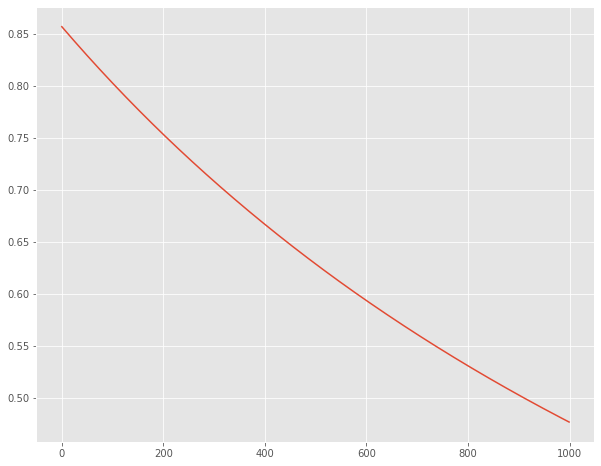

In [265]:
epochs = 1000
lr = 0.01
norm = 1/xtr.shape[0]
losses = []
for i in range(epochs):
    z1 = np.matmul(xtr, w1) + b1
    y1 = RelU(z1)
    z2 = np.matmul(y1, w2) + b2
    y2 = softmax(z2)
    losses.append(norm * np.sum(np.multiply(-1*np.log(y2), ytr)))
    acc = np.sum(np.argmax(y2, axis= 1) == np.argmax(ytr, axis= 1))/(ytr.shape[0])
    if i%100==0:
        print(f"The accuracy for iteration {i} is : {acc*100}%")
        print("loss is", losses[-1])
    grad_z2 = y2 - ytr
    grad_w2 = np.matmul(y1.T, grad_z2)
    grad_y1 = np.matmul(grad_z2, w2.T)
    grad_z1 = grad_y1 * RelU_derivative(z1)
    grad_w1 = np.matmul(xtr.T, grad_z1)
    grad_b2 = np.sum(grad_z2, axis = 0).reshape(1,-1) 
    grad_b1 = np.sum(grad_z1, axis = 0).reshape(1,-1)

    # update:
    w2-=lr*norm*grad_w2
    w1-=lr*norm*grad_w1
    b2-=lr*norm*grad_b2
    b1-=lr*norm*grad_b1
plt.figure(figsize= (10,8))
plt.plot(np.arange(epochs), losses)


In [38]:
class Model():
    def __init__(self, xtr, ytr, hidden_unit = 150, epochs = 1000, lr = 0.01):
        np.random.seed(42)
        self.hidden_units = hidden_unit
        self.xtr = xtr.T
        self.ytr = ytr.T
        self.w1 = np.random.uniform(-1,1, size = (self.xtr.shape[1], self.hidden_units))
        self.b1 = np.random.uniform(-1,1, size = (1, self.hidden_units))
        self.w2 = np.random.uniform(-1,1, size = (self.hidden_units, self.ytr.shape[1]))
        self.b2 = np.random.uniform(-1,1, size = (1, self.ytr.shape[1]))
        self.epochs = epochs
        self.lr = lr
        self.norm = 1/xtr.shape[0]
        self.losses = []
        self.acc = 0
    
    def forward_pass(self):
        # xtr :  number of examples x vocab_size
        self.z1 = np.matmul(self.xtr, self.w1) + self.b1
        self.y1 = RelU(self.z1)
        self.z2 = np.matmul(self.y1, self.w2) + self.b2
        self.y2 = softmax(self.z2)
        #self.acc = np.sum(np.argmax(self.y2, axis= 1) == np.argmax(self.ytr, axis= 1))/(self.ytr.shape[0])
        #print(f"The accuracy is: {self.acc*100}%")

    def RelU_derivative(self, x):
        return np.where(x>0, 1, 0)

    
    def back_prop(self):
        for i in range(self.epochs):
            self.forward_pass()
            # z1 = np.matmul(xtr, w1) + b1
            # y1 = RelU(z1)
            # z2 = np.matmul(y1, w2) + b2
            # y2 = softmax(z2)
            self.losses.append(self.norm * np.sum(np.multiply(-1*np.log(self.y2), self.ytr)))
            self.acc = np.sum(np.argmax(self.y2, axis= 1) == np.argmax(self.ytr, axis= 1))/(self.ytr.shape[0])
            if i%100==0:
                print(f"The accuracy for iteration {i} is : {self.acc*100}%")
                print("loss is", self.losses[-1])
            self.grad_z2 = self.y2 - self.ytr
            self.grad_w2 = np.matmul(self.y1.T, self.grad_z2)
            self.grad_y1 = np.matmul(self.grad_z2, self.w2.T)
            self.grad_z1 = self.grad_y1 * self.RelU_derivative(self.z1)
            self.grad_w1 = np.matmul(self.xtr.T, self.grad_z1)
            self.grad_b2 = np.sum(self.grad_z2, axis = 0).reshape(1,-1) 
            self.grad_b1 = np.sum(self.grad_z1, axis = 0).reshape(1,-1)

            # update:
            self.w2-=self.lr*self.norm*self.grad_w2
            self.w1-=self.lr*self.norm*self.grad_w1
            self.b2-=self.lr*self.norm*self.grad_b2
            self.b1-=self.lr*self.norm*self.grad_b1
        plt.figure(figsize= (10,8))
        plt.plot(np.arange(self.epochs), self.losses)



The accuracy for iteration 0 is : 2.605570530098832%
loss is 23.666479451505534
The accuracy for iteration 100 is : 20.125786163522015%
loss is 9.766023625125175
The accuracy for iteration 200 is : 33.24348607367475%
loss is 6.787545145477955
The accuracy for iteration 300 is : 44.923629829290206%
loss is 5.165371729057073
The accuracy for iteration 400 is : 52.7403414195867%
loss is 4.184270630921931
The accuracy for iteration 500 is : 57.41239892183289%
loss is 3.4993271191518827
The accuracy for iteration 600 is : 61.27583108715184%
loss is 2.986292248538227
The accuracy for iteration 700 is : 65.5884995507637%
loss is 2.5871080029184745
The accuracy for iteration 800 is : 68.91284815813118%
loss is 2.2657333376064708
The accuracy for iteration 900 is : 71.0691823899371%
loss is 2.0009739533201625


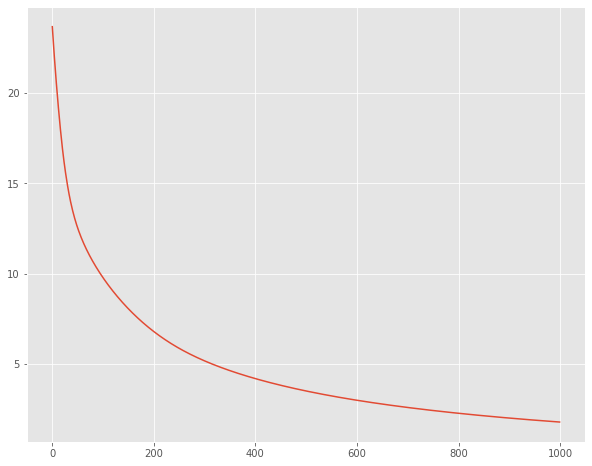

In [39]:
model = Model(xtr, ytr)
model.back_prop()

Your discussion here

## Bonus: Mini-Batch and Stochastic Gradient Descent [15pts]

<div class="alert alert-block alert-info">
    
As a bonus, train the neural network using mini-batch gradient descent with batch size = 64 and stochastic gradient descent (i.e., batch size = 1) for 1000 epoch using learning rate = 0.005. Plot the cost vs iteration for both cases and briefly discuss your observation!  

</div>

In [56]:
class Model_mini_batches():
    def __init__(self, xtr, ytr, hidden_unit = 150, epochs = 1000, lr = 0.01, batchsize = 64):
        np.random.seed(42)
        self.hidden_units = hidden_unit
        self.xtr = xtr.T
        self.ytr = ytr.T
        self.w1 = np.random.uniform(-1,1, size = (self.xtr.shape[1], self.hidden_units))
        self.b1 = np.random.uniform(-1,1, size = (1, self.hidden_units))
        self.w2 = np.random.uniform(-1,1, size = (self.hidden_units, self.ytr.shape[1]))
        self.b2 = np.random.uniform(-1,1, size = (1, self.ytr.shape[1]))
        self.epochs = epochs
        self.lr = lr
        self.losses = []
        self.acc = 0
        self.batchsize = batchsize
        self.norm = 1/self.batchsize
    
    def forward_pass(self):
        # xtr :  number of examples x vocab_size
        self.z1 = np.matmul(self.xmini, self.w1) + self.b1
        self.y1 = RelU(self.z1)
        self.z2 = np.matmul(self.y1, self.w2) + self.b2
        self.y2 = softmax(self.z2)
        #self.acc = np.sum(np.argmax(self.y2, axis= 1) == np.argmax(self.ytr, axis= 1))/(self.ytr.shape[0])
        #print(f"The accuracy is: {self.acc*100}%")

    def RelU_derivative(self, x):
        return np.where(x>0, 1, 0)

    
    def back_prop(self):
        for i in range(self.epochs):
            if (i%25==0) & (i>0):
                print(f"The accuracy for iteration {i} is : {self.acc*100}%")
                print("loss is", self.losses[-1])
            for j in range((self.xtr.shape[0]//64) + 1):
                self.xmini = self.xtr[j*self.batchsize: j*self.batchsize+self.batchsize, :]
                self.ymini = self.ytr[j*self.batchsize: j*self.batchsize+self.batchsize, :]
                self.forward_pass()
                self.losses.append(self.norm * np.sum(np.multiply(-1*np.log(self.y2), self.ymini)))
                self.acc = np.sum(np.argmax(self.y2, axis= 1) == np.argmax(self.ymini, axis= 1))/(self.ymini.shape[0])
                self.grad_z2 = self.y2 - self.ymini
                self.grad_w2 = np.matmul(self.y1.T, self.grad_z2)
                self.grad_y1 = np.matmul(self.grad_z2, self.w2.T)
                self.grad_z1 = self.grad_y1 * self.RelU_derivative(self.z1)
                self.grad_w1 = np.matmul(self.xmini.T, self.grad_z1)
                self.grad_b2 = np.sum(self.grad_z2, axis = 0).reshape(1,-1) 
                self.grad_b1 = np.sum(self.grad_z1, axis = 0).reshape(1,-1)

                # update:
                self.w2-=self.lr*self.norm*self.grad_w2
                self.w1-=self.lr*self.norm*self.grad_w1
                self.b2-=self.lr*self.norm*self.grad_b2
                self.b1-=self.lr*self.norm*self.grad_b1
        plt.figure(figsize= (10,8))
        plt.plot(np.arange(self.epochs * ((self.xtr.shape[0]//64) + 1)), self.losses)
        plt.xlabel("Number of Epochs")
        plt.ylabel("Losses")
        plt.title("Epochs vs Loss")



Your discussion here

The accuracy for iteration 25 is : 76.0%
loss is 0.40509813403349504
The accuracy for iteration 50 is : 88.0%
loss is 0.19972708701686576
The accuracy for iteration 75 is : 88.0%
loss is 0.11917506084787449


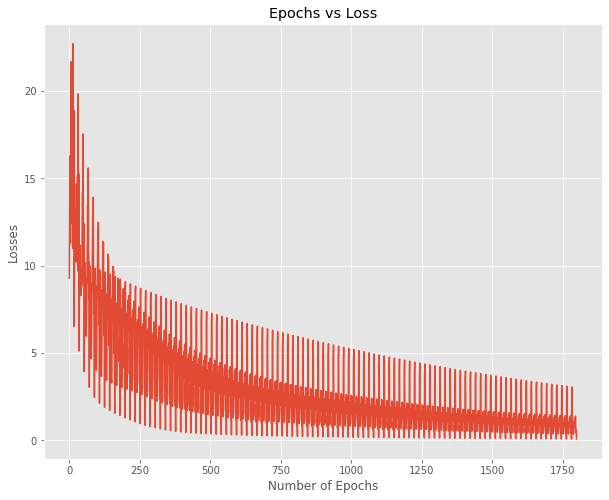

In [57]:
model = Model_mini_batches(xtr, ytr, epochs= 100)
model.back_prop()

#### Stocastic Gradient Descent

The accuracy for iteration 25 is : 100.0%
loss is 0.0005471032878999835
The accuracy for iteration 50 is : 100.0%
loss is 0.00034596263138526
The accuracy for iteration 75 is : 100.0%
loss is 0.0002636168942135405


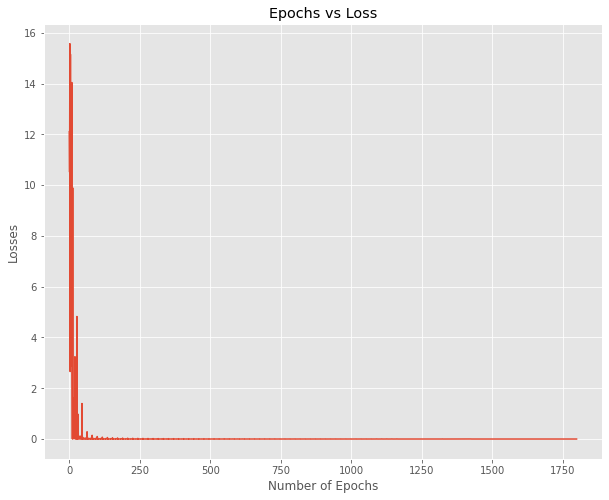

In [58]:
model = Model_mini_batches(xtr, ytr, epochs= 100, batchsize= 1)
model.back_prop()